## CSML1010 Group3 Course_Project - Milestone 2 - Baseline Machine Learning Implementation
#### Authors (Group3): Paul Doucet, Jerry Khidaroo
#### Project Repository: https://github.com/CSML1010-3-2020/NLPCourseProject

#### Dataset:
The dataset used in this project is the __Taskmaster-1__ dataset from Google.
[Taskmaster-1](https://research.google/tools/datasets/taskmaster-1/)

The dataset can be obtained from: https://github.com/google-research-datasets/Taskmaster

---

## Workbook Setup and Data Preparation

#### Import Libraries

In [1]:
# import pandas, numpy
import pandas as pd
import numpy as np
import re
import nltk


#### Set Some Defaults

In [2]:
# adjust pandas display
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.7f}'.format
pd.options.display.precision = 7
pd.options.display.max_colwidth = None

# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')

#### Load Data

In [3]:
df_all = pd.read_csv('./data/dialog_norm.csv')
df_all.columns

Index(['Instruction_id', 'category', 'selfdialog_norm'], dtype='object')

In [4]:
df_all.head(3)

,Instruction_id,category,selfdialog_norm
0,restaurant-table,0,restauranttable
1,movie-tickets-1,1,hi would like see movie men want playing yes showing would like purchase ticket yes friend two tickets please okay time moving playing today movie showing pm okay anymore movies showing around pm yes showing pm green book two men dealing racisim oh recommend anything else like well like movies funny like comedies well like action well okay train dragon playing pm okay get two tickets want cancel tickets men want yes please okay problem much cost said two adult tickets yes okay okay anything else help yes bring food theater sorry purchase food lobby okay fine thank enjoy movie
2,movie-tickets-3,2,want watch avengers endgame want watch bangkok close hotel currently staying sounds good time want watch movie oclock many tickets two use account already movie theater yes seems movie time lets watch another movie movie want watch lets watch train dragon newest one yes one dont think movie playing time either neither choices playing time want watch afraid longer interested watching movie well great day sir thank welcome


#### Remove NaN rows

In [5]:
print(df_all.shape)
df_all = df_all.dropna()
df_all = df_all.reset_index(drop=True)
df_all = df_all[df_all.selfdialog_norm != '']
print(df_all.shape)

(7706, 3)
(7706, 3)


In [6]:
print (df_all.groupby('Instruction_id').size())

Instruction_id
auto-repair-appt-1    1160
coffee-ordering       1376
movie-finder            54
movie-tickets-1        678
movie-tickets-2        377
movie-tickets-3        195
pizza-ordering        1468
restaurant-table      1198
restaurant-table-3     102
uber-lyft             1098
dtype: int64


In [7]:
#weight_higher = ['restaurant-table-2', 'movie-tickets-1', 'movie-tickets-3','uber-lift-2','coffee-ordering-1','coffee-ordering-2','pizza-ordering-2','movie-finder']
class_sample_size_dict = {
    "auto-repair-appt-1": 230,
    "coffee-ordering": 230,
    "movie-finder": 54,
    "movie-tickets-1": 250,
    "movie-tickets-2": 250,
    "movie-tickets-3": 195,
    "pizza-ordering": 230,
    "restaurant-table": 230,
    "restaurant-table-3": 101,
    "uber-lyft": 230
}
sum(class_sample_size_dict.values())

2000

#### Get a Sample of records.

In [9]:
# Function to Get balanced Sample - Get a bit more than needed then down sample
def sampling_k_elements(group):
    name = group['Instruction_id'].iloc[0]
    k = class_sample_size_dict[name]
    return group.sample(k, random_state=5)

#Get balanced samples
corpus_df = df_all.groupby('Instruction_id').apply(sampling_k_elements).reset_index(drop=True)
print (corpus_df.groupby('Instruction_id').size(), corpus_df.shape)

Instruction_id
auto-repair-appt-1    230
coffee-ordering       230
movie-finder           54
movie-tickets-1       250
movie-tickets-2       250
movie-tickets-3       195
pizza-ordering        230
restaurant-table      230
restaurant-table-3    101
uber-lyft             230
dtype: int64 (2000, 3)


#### Generate Corpus List

In [10]:
doc_lst = []
for i, row in corpus_df.iterrows():
    doc_lst.append(row.selfdialog_norm)

print(len(doc_lst))
doc_lst[1:5]

2000


['hi im issue car help sure whats problem light came saying headlight ok want get fixed right away today would ideal already know want take yes intelligent auto solutions ok let pull website online scheduler see today ok im looks like two appointments open today could minutes im least minutes away ok time would pm tonight tell able fix spot call confirm makemodel car kia soul ok said parts done appointment thats great news please book yes booked online thanks give info yes text youll phone thank big help',
 'hi schedule appointment car okay auto repair shop would like check check intelligent auto solutions car bringing lexus im driving put name cell phone number yes put jeff green cell phone number seems problem car makes sound step brakes anything else would like check like oil change maintenance yes think im due oil change well got let check online see available check bring mins able make appointment bring car time pm great thanks initial cost brake checkup oil change okay accept cre

#### Split Data into Train and Test Sets

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(doc_lst, corpus_df['category'], test_size=0.25, random_state = 0)

#### Build Vocabulary

In [12]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer(lower=False)
tokenizer.fit_on_texts(X_train)
word2id = tokenizer.word_index

word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in X_train]

vocab_size = len(word2id)
embed_size = 100
window_size = 2

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Using TensorFlow backend.
Vocabulary Size: 4822
Vocabulary Sample: [('tickets', 1), ('pm', 2), ('like', 3), ('would', 4), ('ok', 5), ('okay', 6), ('movie', 7), ('yes', 8), ('see', 9), ('want', 10)]


### Bag of Words Feature Extraction

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1., vocabulary=word2id)
cv_matrix = cv.fit_transform(X_train, y_train)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 3, 2, ..., 0, 0, 0],
       [0, 4, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 3, 3, ..., 1, 1, 1],
       [0, 2, 3, ..., 0, 0, 0]], dtype=int64)

In [60]:
# get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

,PAD,tickets,pm,like,would,ok,okay,movie,yes,see,want,time,showing,need,thank,...,customers,reald,caption,promotions,kingstown,allows,glowing,blackstone,marinos,pizzaeria,oky,indianapolis,riveria,lke,muh
0,0,3,2,5,4,0,3,3,1,1,1,4,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,4,1,4,4,0,0,1,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,4,3,1,1,0,7,1,1,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,5,3,1,1,7,0,2,0,2,2,1,4,2,3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0,1,1,4,4,1,7,1,3,1,0,3,3,0,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1496,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1497,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1498,0,3,3,3,4,5,0,6,2,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1


In [61]:
# Get BOW features
X_train_bow = cv_matrix #cv.fit_transform(X_train).toarray()
X_test_bow = cv.transform(X_test).toarray()
y_train = np.array(y_train)
y_test = np.array(y_test)
print (X_train_bow.shape) 
print (X_test_bow.shape) 
print (y_test.shape)

(1500, 4822)
(500, 4822)
(500,)


#### Define Model Builder Function

In [62]:
#from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics

class Result_Metrics:
    def __init__(self, predicter, cm, report, f1_score, accuracy, precision, recall):
        self.predicter = predicter
        self.cm = cm    # instance variable unique to each instance
        self.report = report
        self.f1_score = f1_score
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall

def Build_Model(model, features_train, labels_train, features_test, labels_test):
    classifier = model.fit(features_train, labels_train)

    # Predicter to output
    pred = classifier.predict(features_test)

    # Metrics to output
    cm = confusion_matrix(pred,labels_test)
    report = metrics.classification_report(labels_test, pred)
    f1 = metrics.f1_score(labels_test, pred, average='weighted')
    accuracy = cm.trace()/cm.sum()
    precision = metrics.precision_score(labels_test, pred, average='weighted')
    recall = metrics.recall_score(labels_test, pred, average='weighted')
    
    rm = Result_Metrics(pred, cm, report, f1, accuracy, precision, recall)

    return rm

### Bag of Words Feature Benchmarking Baseline with Naive Bayes Classifier

In [63]:
from sklearn.naive_bayes import MultinomialNB

model_nb_bow = MultinomialNB()
rm_nb_bow = Build_Model(model_nb_bow, X_train_bow, y_train, X_test_bow, y_test)

In [64]:

def Save_Benchmark(descr, feat_type, b_metrics, reset_rb, reset_rb_all):
    global rows_benchmarks
    global rows_benchmarks_all
    global df_benchmarks
    global df_benchmarks_all
    if (reset_rb):
        rows_benchmarks = []

    if (reset_rb_all):
        rows_benchmarks_all = []
    rows_benchmarks.append([descr, feat_type, b_metrics.precision, b_metrics.recall, b_metrics.f1_score, b_metrics.accuracy])
    rows_benchmarks_all.append([descr, feat_type, b_metrics.precision, b_metrics.recall, b_metrics.f1_score, b_metrics.accuracy])
    df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "Feat_Type", "Precision", "Recall", "f1_score", "accuracy"])
    df_benchmarks_all = pd.DataFrame(rows_benchmarks_all, columns=["Features_Benchedmarked", "Feat_Type", "Precision", "Recall", "f1_score", "accuracy"])


In [65]:
# Save benchmark output
Save_Benchmark("BOW Naive Bayes Baseline", "BOW", rm_nb_bow, True, True)
#df_benchmarks

In [66]:
from sklearn.metrics import confusion_matrix
#rm_nb_bow.cm

In [67]:
from sklearn import metrics
#print("Label" + rm_nb_bow.report)

### Feature Selection: BOW Features with Naive Bayes Model Using Chi-Squared Selector

#### Define Feature Selection Functions

In [68]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

class Result_Metrics_selected:
    def __init__(self, x_train_sel, x_test_sel, predicter, cm, report, f1_score, accuracy, precision, recall):
        self.x_train_sel = x_train_sel
        self.x_test_sel = x_test_sel
        self.predicter = predicter
        self.cm = cm    # instance variable unique to each instance
        self.report = report
        self.f1_score = f1_score
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall

def Get_Scaled_Features(features_train, labels_train, features_test, labels_test, scaler):
    x_train_scaled = scaler.fit_transform(features_train, labels_train)
    x_test_scaled = scaler.transform(features_test)
    return x_train_scaled, x_test_scaled

def Select_Best_Features_Chi(num_feats, features_train, labels_train, features_test, labels_test):
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(features_train, labels_train)
    chi_support = chi_selector.get_support()    
    X_train_chi = features_train[:,chi_support]
    X_test_chi = features_test[:,chi_support]
    return X_train_chi, X_test_chi

def Get_Model_Feature_Metrics(model, num_feats, features_train, labels_train, features_test, labels_test, scaler):
    X_train_chi, X_test_chi = Select_Best_Features_Chi(num_feats, features_train, labels_train, features_test, labels_test)
    x_train_scaled, x_test_scaled = Get_Scaled_Features(X_train_chi, labels_train, X_test_chi, labels_test, scaler)
    rm_chi = Build_Model(model, x_train_scaled, labels_train, x_test_scaled, labels_test)
    return rm_chi

def SelectBestModelFeatures_Chi(model, num_feats, features_train, labels_train, features_test, labels_test, scaler):
    X_norm = scaler.fit_transform(features_train, labels_train)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, labels_train)
    chi_support = chi_selector.get_support()
    
    X_train_chi = features_train[:,chi_support]
    X_test_chi = features_test[:,chi_support]

    classifier_chi = model.fit(X_train_chi, labels_train)

    # Predicter to output
    predict_chi = classifier_chi.predict(X_test_chi)

    # Metrics to output
    cm_chi = confusion_matrix(predict_chi,labels_test)
    report_chi = metrics.classification_report(labels_test, predict_chi)
    f1_chi = metrics.f1_score(labels_test, predict_chi, average='weighted')
    accuracy_chi = cm_chi.trace()/cm_chi.sum()
    precision_chi = metrics.precision_score(labels_test, predict_chi, average='weighted')
    recall_chi = metrics.recall_score(labels_test, predict_chi, average='weighted')
    
    rm_chi = Result_Metrics_selected(X_train_chi, X_test_chi, predict_chi, cm_chi, report_chi, f1_chi, accuracy_chi, precision_chi, recall_chi)

    return rm_chi

#### Iterate through number of features and get benchmark results

In [69]:
a = 100
tot = X_train_bow.shape[1]
b = 100 * (tot//100)
c = 100
print(a, b, c)

100 4800 100


In [70]:
rows = []

scaler_min_max = MinMaxScaler()
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.
    #rm_chi_i = Get_Model_Feature_Metrics(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)
    rm_chi_i = SelectBestModelFeatures_Chi(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)
    rows.append([i, rm_chi_i.f1_score, rm_chi_i.accuracy])
    sys.stdout.write('\r'+str(i) + "/" + str(b))
    sys.stdout.flush()

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])


4700/4800

#### Plot f1-score by number of selected features

In [71]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
a = Opt_no_of_feat - 50
b = Opt_no_of_feat + 50
c = 1
print(a, b, c)
#acc_df.sort_values(by='f1_score', ascending=False).head(5)

750 850 1


#### Get a more fine-grained look at the optimal number of features region

In [72]:
rows = []
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.
    rm_chi_i = SelectBestModelFeatures_Chi(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)
    rows.append([i, rm_chi_i.f1_score, rm_chi_i.accuracy])
    sys.stdout.write('\r'+str(i) + "/" + str(b))
    sys.stdout.flush()

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

849/850

In [73]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
print(Opt_no_of_feat)
#acc_df.sort_values(by='f1_score', ascending=False).head(5)

849


#### Benchmark BOW With Optimal Features Selected using Naive Bayes Model

In [74]:
model_nb_bow_opt = MultinomialNB()
rm_chi_opt_bow = SelectBestModelFeatures_Chi(model_nb_bow, Opt_no_of_feat, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)

In [75]:
# Save benchmark output
Save_Benchmark("BOW Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), "BOW", rm_chi_opt_bow, False, False)
df_benchmarks

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,BOW Naive Bayes Baseline,BOW,0.9306527,0.9240000,0.9253405,0.9240000
1,BOW Naive Bayes Optimal Features Selected: 849,BOW,0.9478845,0.9440000,0.9449159,0.9440000


---

## 1. Benchmark Comparison

### Benchmark the following four models: Logistic Regression (Multinomial) Naive Bayes Linear Support Vector Machine Random Forest

In [76]:
# Manage Results List
entries = []
def Result_Update_Or_Append(model_id, model_name, feat_status, hyper_param_status, best_params, f1_score, reset_entr):
    global entries
    if (reset_entr):
        entries = []
        entries.append([model_id, model_name, feat_status, hyper_param_status, best_params, f1_score])
    else:
        for i in range(len(entries)):
            if entries[i][0] == model_id and entries[i][1] == model_name and entries[i][2] == feat_status and entries[i][3] == hyper_param_status:
                entries[i][4] = best_params
                entries[i][5] = f1_score
                break
            else:
                entries.append((model_id, model_name, feat_status, hyper_param_status, best_params, f1_score))
                break

#### Baseline Features

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_jobs=-1),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(n_jobs=-1),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
    model_name = model.__class__.__name__
    f1_scores = cross_val_score(model, X_train_bow, y_train, scoring='f1_weighted', cv=CV)
    precisions = cross_val_score(model, X_train_bow, y_train, scoring='precision_weighted', cv=CV)
    recalls = cross_val_score(model, X_train_bow, y_train, scoring='recall_weighted', cv=CV)
    
    for i in range(0, 4, 1):
        entries.append((model_name, 'baseline', precisions[i], recalls[i], f1_scores[i]))

cv_df = pd.DataFrame(entries, columns=['model_name', 'features', 'precision', 'recall', 'f1_score'])    

# Interpretability - Features Importances

In [14]:
import random
import pandas as pd
import IPython
import xgboost
import keras

import eli5
from eli5.lime import TextExplainer
from lime.lime_text import LimeTextExplainer
print('ELI5 Version:', eli5.__version__)
print('XGBoost Version:', xgboost.__version__)
print('Keras Version:', keras.__version__)

ELI5 Version: 0.10.1
XGBoost Version: 0.90
Keras Version: 2.3.1


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

In [22]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

from keras.models import Model, Input
from keras.layers import Dense, LSTM, Dropout, Embedding, SpatialDropout1D, Bidirectional, concatenate
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

class KerasTextClassifier:
    __author__ = "Edward Ma"
    __copyright__ = "Copyright 2018, Edward Ma"
    __credits__ = ["Edward Ma"]
    __license__ = "Apache"
    __version__ = "2.0"
    __maintainer__ = "Edward Ma"
    __email__ = "makcedward@gmail.com"
    
    OOV_TOKEN = "UnknownUnknown"
    
    def __init__(self, 
                 max_word_input, word_cnt, word_embedding_dimension, labels, 
                 batch_size, epoch, validation_split,
                 verbose=0):
        self.verbose = verbose
        self.max_word_input = max_word_input
        self.word_cnt = word_cnt
        self.word_embedding_dimension = word_embedding_dimension
        self.labels = labels
        self.batch_size = batch_size
        self.epoch = epoch
        self.validation_split = validation_split
        
        self.label_encoder = None
        self.classes_ = None
        self.tokenizer = None
        
        self.model = self._init_model()
        self._init_label_encoder(y=labels)
        self._init_tokenizer()
        
    def _init_model(self):
        input_layer = Input((self.max_word_input,))
        text_embedding = Embedding(
            input_dim=self.word_cnt+2, output_dim=self.word_embedding_dimension,
            input_length=self.max_word_input, mask_zero=False)(input_layer)
        
        text_embedding = SpatialDropout1D(0.5)(text_embedding)
        
        bilstm = Bidirectional(LSTM(units=256, return_sequences=True, recurrent_dropout=0.5))(text_embedding)
        x = concatenate([GlobalAveragePooling1D()(bilstm), GlobalMaxPooling1D()(bilstm)])
        x = Dropout(0.5)(x)
        x = Dense(128, activation="relu")(x)
        x = Dropout(0.5)(x)
        
        output_layer = Dense(units=len(self.labels), activation="softmax")(x)
        model = Model(input_layer, output_layer)
        model.compile(
            optimizer="adam",
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"])
        return model
    
    def _init_tokenizer(self):
        self.tokenizer = Tokenizer(
            num_words=self.word_cnt+1, split=' ', oov_token=self.OOV_TOKEN)
    
    def _init_label_encoder(self, y):
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(y)
        self.classes_ = self.label_encoder.classes_
        
    def _encode_label(self, y):
        return self.label_encoder.transform(y)
        
    def _decode_label(self, y):
        return self.label_encoder.inverse_transform(y)
    
    def _get_sequences(self, texts):
        seqs = self.tokenizer.texts_to_sequences(texts)
        return pad_sequences(seqs, maxlen=self.max_word_input, value=0)
    
    def _preprocess(self, texts):
        # Placeholder only.
        return [text for text in texts]
        
    def _encode_feature(self, x):
        self.tokenizer.fit_on_texts(self._preprocess(x))
        self.tokenizer.word_index = {e: i for e,i in self.tokenizer.word_index.items() if i <= self.word_cnt}
        self.tokenizer.word_index[self.tokenizer.oov_token] = self.word_cnt + 1
        return self._get_sequences(self._preprocess(x))
        
    def fit(self, X, y):
        """
            Train the model by providing x as feature, y as label
        
            :params x: List of sentence
            :params y: List of label
        """
        
        encoded_x = self._encode_feature(X)
        encoded_y = self._encode_label(y)
        
        self.model.fit(encoded_x, encoded_y, 
                       batch_size=self.batch_size, epochs=self.epoch, 
                       validation_split=self.validation_split)
        
    def predict_proba(self, X, y=None):
        encoded_x = self._get_sequences(self._preprocess(X))
        return self.model.predict(encoded_x)
    
    def predict(self, X, y=None):
        y_pred = np.argmax(self.predict_proba(X), axis=1)
        return self._decode_label(y_pred)

In [23]:
names = ['Logistic Regression', 'Random Forest', 'XGBoost Classifier', 'Keras']

In [25]:
def build_model(names, x, y):
    pipelines = []
    vec = TfidfVectorizer()
    vec.fit(x)

    for name in names:
        print('train %s' % name)
        
        if name == 'Logistic Regression':
            estimator = LogisticRegression(solver='newton-cg', n_jobs=-1)
            pipeline = make_pipeline(vec, estimator)
        elif name == 'Random Forest':
            estimator = RandomForestClassifier(n_jobs=-1)
            pipeline = make_pipeline(vec, estimator)
        elif name == 'XGBoost Classifier':
            estimator = XGBClassifier()
            pipeline = make_pipeline(vec, estimator)
        elif name == 'Keras':
            pipeline = KerasTextClassifier(
                max_word_input=100, word_cnt=30000, word_embedding_dimension=100, 
                labels=list(set(y_train.tolist())), batch_size=128, epoch=1, validation_split=0.1)
        
        
        pipeline.fit(x, y)
        pipelines.append({
            'name': name,
            'pipeline': pipeline
        })
        
    return pipelines, vec

In [26]:
pipelines, vec = build_model(names, X_train, y_train)

train Logistic Regression
train Random Forest
train XGBoost Classifier
train Keras
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1350 samples, validate on 150 samples
Epoch 1/1
1350/1350 [==============================] - 15s 11ms/step - loss: 2.2109 - accuracy: 0.2007 - val_loss: 1.8808 - val_accuracy: 0.2333


## ELI5 - Global Interpretation

In [27]:
for pipeline in pipelines:
    print('Estimator: %s' % (pipeline['name']))
    labels = pipeline['pipeline'].classes_.tolist()
    
    if pipeline['name'] in ['Logistic Regression', 'Random Forest']:
        estimator = pipeline['pipeline']
    elif pipeline['name'] == 'XGBoost Classifier':
        estimator = pipeline['pipeline'].steps[1][1].get_booster()
#     Not support Keras
#     elif pipeline['name'] == 'keras':
#         estimator = pipeline['pipeline']
    else:
        continue
    
    IPython.display.display(
        eli5.show_weights(estimator=estimator, top=10, target_names=labels, vec=vec))

Estimator: Logistic Regression


Estimator: Random Forest


Weight,Feature
0.1022 ± 0.1030,coffeeordering
0.1003 ± 0.1009,restauranttable
0.0984 ± 0.1113,uberlyft
0.0821 ± 0.1235,pizzaordering
0.0164 ± 0.0467,tickets
0.0130 ± 0.0555,car
0.0120 ± 0.0423,like
0.0116 ± 0.0349,movie
0.0096 ± 0.0323,see
0.0091 ± 0.0444,intelligent


Estimator: XGBoost Classifier


Weight,Feature
0.0605,pizzaordering
0.0605,uberlyft
0.0600,coffeeordering
0.0595,restauranttable
0.0544,car
0.0318,restaurant
0.0255,tickets
0.0228,table
0.0227,seen
0.0168,appointment


Estimator: Keras


## ELI5 - Local Interpretation

In [28]:
number_of_sample = 1
sample_ids = [random.randint(0, len(X_test) -1 ) for p in range(0, number_of_sample)]

for idx in sample_ids:
    print('Index: %d' % (idx))
#     print('Index: %d, Feature: %s' % (idx, x_test[idx]))
    for pipeline in pipelines:
        print('-' * 50)
        print('Estimator: %s' % (pipeline['name']))
        
        print('True Label: %s, Predicted Label: %s' % (y_test[idx], pipeline['pipeline'].predict([X_test[idx]])[0]))
        labels = pipeline['pipeline'].classes_.tolist()
  
        if pipeline['name'] in ['Logistic Regression', 'Random Forest']:
            estimator = pipeline['pipeline'].steps[1][1]
        elif pipeline['name'] == 'XGBoost Classifier':
            estimator = pipeline['pipeline'].steps[1][1].get_booster()
        #     Not support Keras
#         elif pipeline['name'] == 'Keras':
#             estimator = pipeline['pipeline'].model
        else:
            continue

        IPython.display.display(
            eli5.show_prediction(estimator, X_test[idx], top=10, vec=vec, target_names=labels))

Index: 311
--------------------------------------------------
Estimator: Logistic Regression
True Label: 4, Predicted Label: 2


--------------------------------------------------
Estimator: Random Forest
True Label: 4, Predicted Label: 2


--------------------------------------------------
Estimator: XGBoost Classifier
True Label: 4, Predicted Label: 2


--------------------------------------------------
Estimator: Keras
True Label: 4, Predicted Label: 7


# LIME

## LIME - Local Interpretation

In [29]:
sample_ids = [random.randint(0, len(X_test) -1 ) for p in range(0, number_of_sample)]
sample_ids

[395]

In [31]:
vectorizer = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}', ngram_range=(1, 3), stop_words = 'english', binary=True)
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(train_vectors, y_train)
pred = logreg.predict(test_vectors)
#accuracy = accuracy_score(y_test, pred)
#precision = precision_score(y_test, pred, average='weighted')
#recall = recall_score(y_test, pred, average='weighted')
#f1 = f1_score(y_test, pred, average='weighted')
#print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))


In [33]:
c = make_pipeline(vectorizer, logreg)
class_names=list(corpus_df.category.unique())
explainer = LimeTextExplainer(class_names=class_names)

idx = 3
exp = explainer.explain_instance(X_test[idx], c.predict_proba, num_features=6, labels=[4, 8])
print('Document id: %d' % idx)
print('Predicted class =', class_names[logreg.predict(test_vectors[idx]).reshape(1,-1)[0,0]])
print('True class: %s' % class_names[y_test[idx]])

TypeError: object of type 'NoneType' has no len()

In [34]:
number_of_sample = 1
sample_ids = [random.randint(0, len(X_test) -1 ) for p in range(0, number_of_sample)]

for idx in sample_ids:
    print('Index: %d' % (idx))
    for pipeline in pipelines:
        print('-' * 50)
        print('Estimator: %s' % (pipeline['name']))
        print('True Label: %s, Predicted Label: %s' % (y_test[idx], pipeline['pipeline'].predict([X_test[idx]])[0]))
        labels = class_names=list(corpus_df.category.unique())
        explainer = LimeTextExplainer(class_names=labels)
        exp = explainer.explain_instance(X_test[idx], pipeline['pipeline'].predict_proba, num_features=6, top_labels=5)
        #IPython.display.display(exp.show_in_notebook(text=True))
        

Index: 211
--------------------------------------------------
Estimator: Logistic Regression


KeyError: 211

## Skater

## Skater - Global Interpretation

In [35]:
# Super slow when there is lots of feature(word in this case).......
pipelines, vec = build_model(names, X_train[:2], y_train[:2])

train Logistic Regression
train Random Forest
train XGBoost Classifier
train Keras
Train on 1 samples, validate on 1 samples
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 2.2973 - accuracy: 0.0000e+00 - val_loss: 2.2941 - val_accuracy: 0.0000e+00


--------------------------------------------------
Estimator: Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
[74/74] features ████████████████████ Time elapsed: 1 seconds

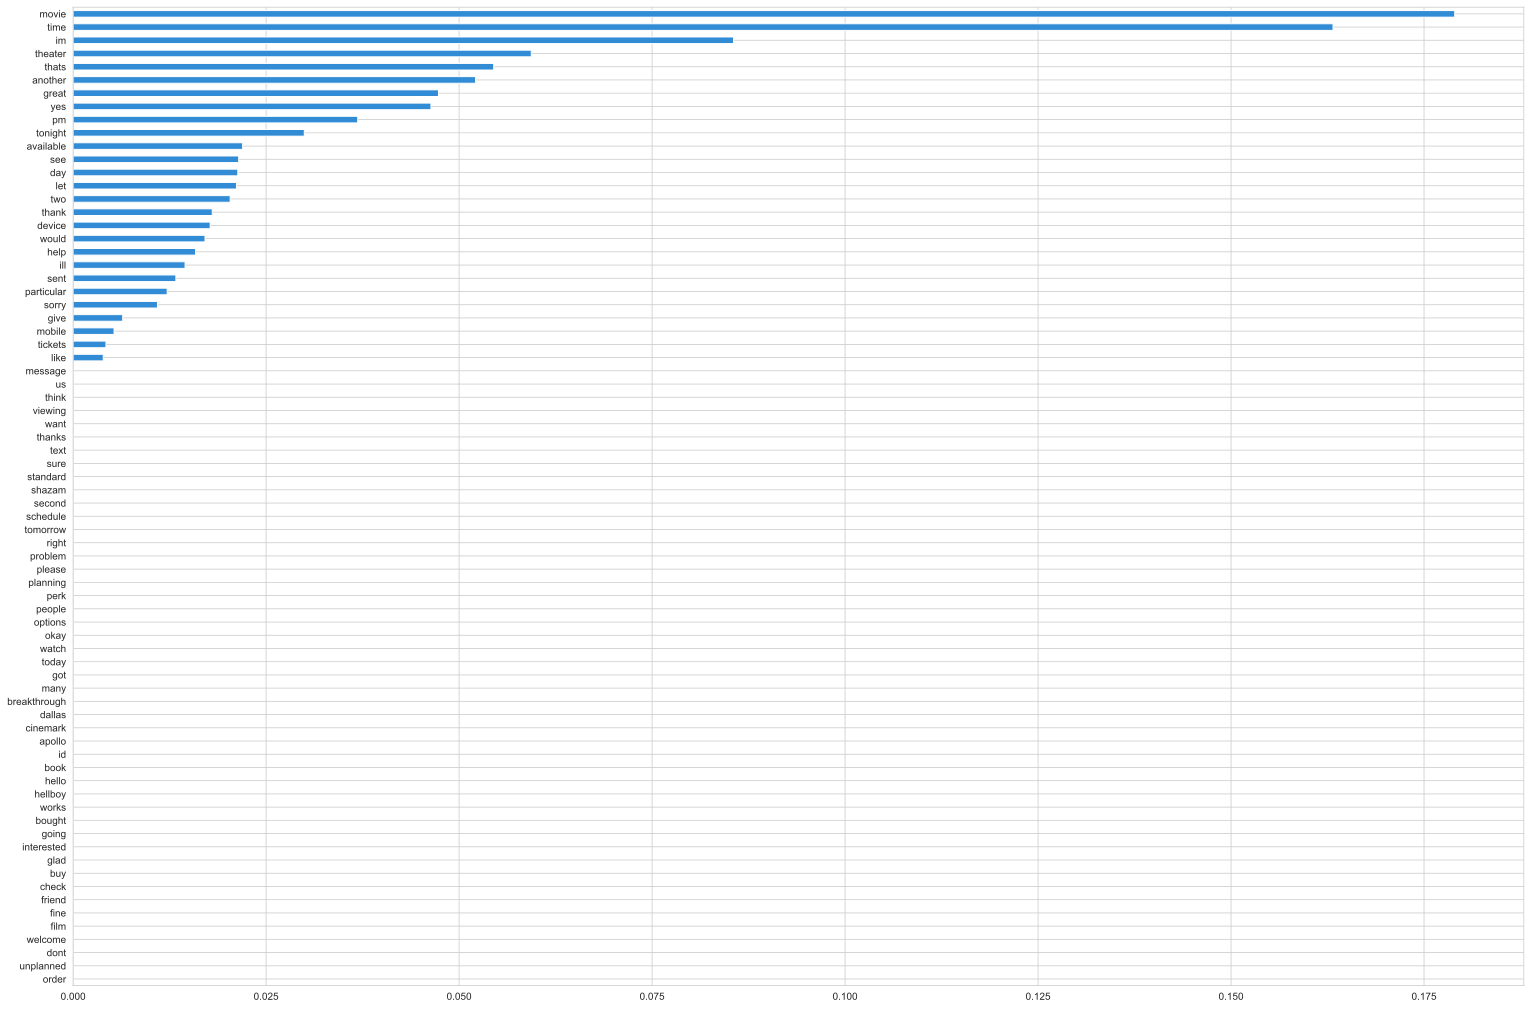

--------------------------------------------------
Estimator: Random Forest
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
[74/74] features ████████████████████ Time elapsed: 8 seconds

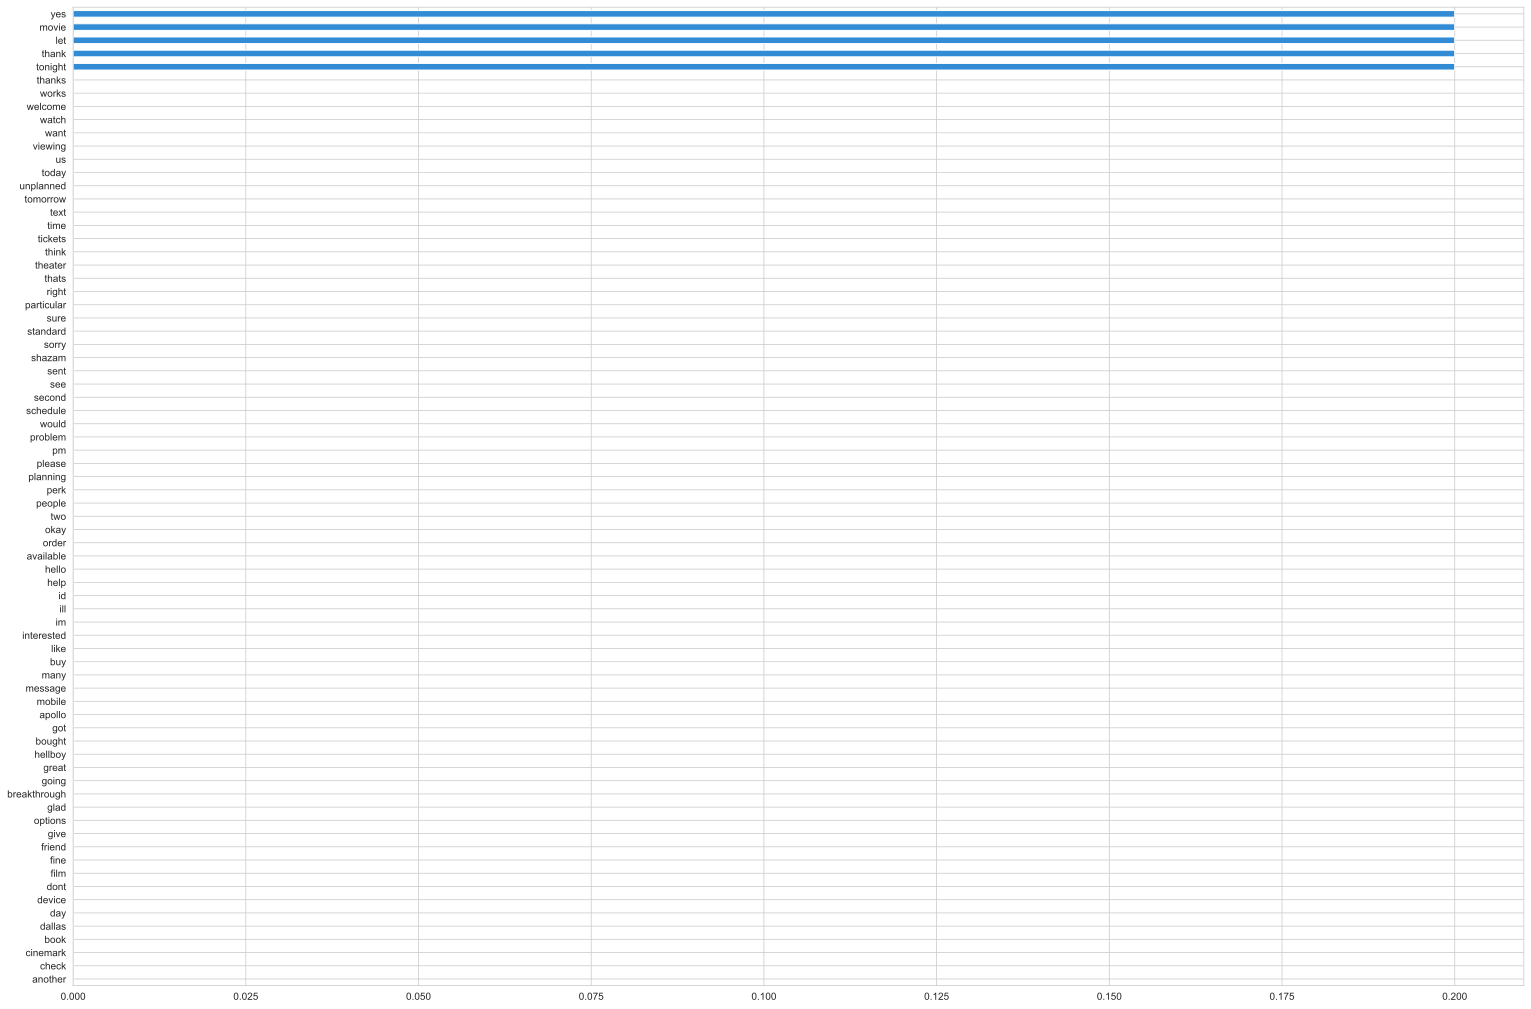

--------------------------------------------------
Estimator: XGBoost Classifier
--------------------------------------------------
Estimator: Keras


In [102]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

from skater.model import InMemoryModel
from skater.core.explanations import Interpretation

transfromed_x_test = vec.transform(X_test[:2]).toarray()

interpreter = Interpretation(transfromed_x_test, feature_names=vec.get_feature_names())

for pipeline in pipelines:
    print('-' * 50)
    print('Estimator: %s' % (pipeline['name']))
    
    if pipeline['name'] in ['Logistic Regression', 'Random Forest']:
        estimator = pipeline['pipeline'].steps[1][1]
    else:
        continue
        
    print(estimator)
        
    pyint_model = InMemoryModel(estimator.predict_proba, examples=transfromed_x_test)
    
    f, axes = plt.subplots(1, 1, figsize = (26, 18))
    ax = axes
    interpreter.feature_importance.plot_feature_importance(pyint_model, ascending=False, ax=ax)
    plt.show()